# Prediction of the Surface Patterns of Metal Nanoparticles: Models Training and Evaluation

This notebook contains the models training and evaluation results from the machine learning predictions of metal nanoparticles. The exercise is an attempt to explore the possibility of using a machine learning model to predict the surface patterns to save computational costs. The surface patterns (labels) are generated using from a clustering approach. The details can be found in [this GitHub repository](https://github.com/Jon-Ting/metal-nanoparticle-surface-atom-labelling.git).

## Outline

[Notebook Setups](#setup)

[Disordered Nanoparticles](#disnps)

<a id='setup'></a>
## Notebook Setups

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# Import relevant libraries
from os import chdir, listdir
from os.path import exists
import pickle
import warnings

import lightgbm
import scipy
import seaborn as sns
import sklearn

from natsort import natsorted
from scipy import stats
# from sklearnex import patch_sklearn; 
# patch_sklearn()
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# chdir('/scratch/q27/jt5911')
from trainEvalModels import *

# Print package versions for reproducibility
print('Versions of imported libraries:')
print(f"  lightgbm: {lightgbm.__version__}")
print(f"  matplotlib: {mpl.__version__}")
print(f"  numpy: {np.__version__}")
print(f"  pandas: {pd.__version__}")
print(f"  scipy: {scipy.__version__}")
print(f"  scikit-learn: {sklearn.__version__}")
print(f"  seaborn: {sns.__version__}")

Versions of imported libraries:
  lightgbm: 4.0.0
  matplotlib: 3.9.2
  numpy: 1.24.4
  pandas: 1.5.3
  scipy: 1.11.1
  scikit-learn: 1.4.0
  seaborn: 0.12.2


Below are some general settings for plotting figures:

In [3]:
# Settings for figures
sns.set_theme(context='paper', style='ticks', palette='colorblind', font='sans-serif', font_scale=1, color_codes=True, rc=None)  # Options are: {paper, notebook, talk, poster}
figSize, fontSize, labelSize = (3.5, 2.5), 'medium', 'small'
legendSize, lineWidth, markerSize = 'x-small', 1, 3
# SMALL_SIZE, MEDIUM_SIZE, LARGE_SIZE, TITLE_SIZE = 8, 10, 12, 14
# plt.rc('font', size=LARGE_SIZE)  # controls default text sizes
# plt.rc('axes', titlesize=TITLE_SIZE)  # fontsize of the axes title
# plt.rc('axes', labelsize=LARGE_SIZE)  # fontsize of the x and y labels
# plt.rc('xtick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
# plt.rc('ytick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
# plt.rc('legend', fontsize=LARGE_SIZE)  # legend fontsize
# plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

In [4]:
# Global variables
SCALING = 'minmax'  # {None, 'minmax', 'standard', 'yeo-johnson'}
POLY_FEATS = False
FIG_NAME_APPENDIX = 'minmax'
NUM_JOBS = 48
VERBOSE = True
RANDOM_SEED = 42

DATA_DIR = '/mnt/c/Users/ASUS/Documents/PhD/Workstation/PaperDrafts/causPath/data'
FIG_DIR = '/mnt/c/Users/ASUS/Documents/PhD/Workstation/PaperDrafts/causPath/figs'

In [5]:
def rmNullFeats(featsDF, verbose=False):
    if verbose:
        print(f"Removing the features with null values...")
        print(f"  Original number of features: {len(featsDF.columns)}")
    featsToDrop = []
    for feat in featsDF.columns:
        if featsDF[feat].isnull().any():
            featsToDrop.append(feat)
    featsNoNullDF = featsDF.drop(featsToDrop, axis=1, inplace=False)
    if verbose:
        print(f"  Total number of features left: {len(featsNoNullDF.columns)}\n")
    return featsNoNullDF

In [6]:
def genModel(hpValDict, modelName):
    if modelName == 'RFR':
        kwargs = {'n_estimators': 100, 'criterion': 'squared_error', 
                  # Adjust to deal with overfitting and speed up training
                  'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 
                  'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.0, 'ccp_alpha': 0.0, 
                  # Parameters to be fixed
                  'min_weight_fraction_leaf': 0.0, 'bootstrap': True, 'warm_start': False, 
                  'monotonic_cst': None, 'oob_score': False, 'n_jobs': NUM_JOBS, 'random_state': RANDOM_SEED, 'verbose': 0}
    elif modelName == 'LGB':
        kwargs = {'num_leaves': 31, 'min_child_samples': 20, 'learning_rate': 0.1, 'n_estimators': 100, 
                  # Adjust to deal with overfitting
                  'min_child_weight': 0.001, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 
                  'subsample': 1.0, 'subsample_freq': 0, 'colsample_bytree': 1.0, 
                  # Adjust to speed up training
                  'min_split_gain': 0.0, 'subsample_for_bin': 200000, 'max_bin': 255, 'max_depth': -1, 
                  # Parameters to be fixed
                  'boosting_type': 'gbdt', 'importance_type': 'gain', 'tree_learner': 'data', 
                  'objective': 'regression', 'class_weight': None, 'use_missing': True,
                  'random_state': RANDOM_SEED, 'n_jobs': NUM_JOBS, 'force_row_wise': True, 'verbose': -1}

    for hp in hpValDict.keys():
        kwargs[hp] = hpValDict[hp]
        
    if modelName == 'RFR':
        return RandomForestRegressor(**kwargs)
    elif modelName == 'LGB':
        return LGBMRegressor(**kwargs)

In [7]:
def getTrainTestScores(dataset, hpsValsDicts, modelName):
    Xtrain, Xtest, yTrain, yTest = dataset
    trainScores, testScores = [], []
    for hpsValsDict in hpsValsDicts:
        reg = genModel(hpsValsDict, modelName)
        reg.fit(Xtrain, yTrain)
        trainScores.append(reg.score(Xtrain, yTrain))
        testScores.append(reg.score(Xtest, yTest))
    return trainScores, testScores

In [8]:
def hpVSr2(xVals, scores, xlabel, figSize=(7, 2.5)):
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#303F9F', '#FF5252', '#D32F2F'])
    if len(scores) == 1:
        trainScores, testScores = scores[0]
        plt.figure(figsize=figSize)
        if all(isinstance(xVal, str) for xVal in xVals):
            plt.bar(xVals, trainScores)
            plt.bar(xVals, testScores)
        else:
            plt.plot(xVals, trainScores)
            plt.plot(xVals, testScores)
            plt.xlabel(xlabel)
        plt.grid(linestyle='dotted')
        plt.ylabel('R2 score')
        plt.legend(['Train', 'Test']);
    else:
        fig, axes = plt.subplots(1, len(scores), figsize=figSize)
        for i, (trainScores, testScores) in enumerate(scores):
            if all(isinstance(xVal, str) for xVal in xVals):
                axes[i].bar(xVals, trainScores)
                axes[i].bar(xVals, testScores)
            else:
                axes[i].plot(xVals, trainScores)
                axes[i].plot(xVals, testScores)
            axes[i].grid(linestyle='dotted')
            axes[i].legend(['Train', 'Test'])
        fig.text(0.5, -0.03, xlabel, ha='center')
        fig.text(0.05, 0.5, 'R2 score', va='center', rotation='vertical');

<a id='disnps'></a>
## Disordered Nanoparticles

Here we attempt to train a machine learning model that aims to predict the surface patterns of a disordered palladium nanoparticle, study the feature importance profile to understand the influential features in the prediction of the surface patterns, and investigate the conditions that give rise to rougher nanoparticles.

### Data Loading

In [9]:
CORR_THRESH = 0.90

with open(f"{DATA_DIR}/processeddisNPsurfDataNoC{int(CORR_THRESH * 100)}.pickle", 'rb') as f:
    disNPDF = pickle.load(f)
disNPNoNullDF = rmNullFeats(featsDF=disNPDF, verbose=VERBOSE)

Removing the features with null values...
  Original number of features: 41
  Total number of features left: 41



The features in the monometallic datasets do not contain any missing values.

In [10]:
XtrainDisNP, XtestDisNP, yTrainDisNP, yTestDisNP = splitScaleData(df=disNPDF, polyFeats=POLY_FEATS, scaling=SCALING, isReg=False, verbose=VERBOSE)
XtrainDisNPNoNull, XtestDisNPNoNull, yTrainDisNPNoNull, yTestDisNPNoNull = splitScaleData(df=disNPNoNullDF, polyFeats=POLY_FEATS, scaling=SCALING, isReg=False, verbose=VERBOSE)

X_Y_disNPS = {'WithNull': {'disNP': (XtrainDisNP, XtestDisNP, yTrainDisNP, yTestDisNP)}, 
              'NoNull': {'disNP': (XtrainDisNPNoNull, XtestDisNPNoNull, yTrainDisNPNoNull, yTestDisNPNoNull)}}

Applying minmax scaling to feature values...
Applying minmax scaling to feature values...


### Models Training and Evaluation

The chosen regression models are trained on different monometallic nanoparticle datasets (gold, palladium, platinum, and all three datasets combined) without polynomial features, with features scaled via min-max normalisation.

##### Logistic Regressor

Logistic regressor is chosen as a baseline. 


Dataset: disNP
Best score: 0.877
Best parameter combination: {'C': 3.5503048581283054, 'penalty': 'l2', 'tol': 6.170217483403153e-05}
  Running LRRsurf
  Trained and tested using Weighted F1 score.
    Training score: 0.944
    Cross-validation score: 0.877 +/- 0.029
    Testing score:
              precision    recall  f1-score   support

     Class 1      0.854     0.897     0.875        39
     Class 2      0.750     0.750     0.750        16
     Class 3      0.000     0.000     0.000         3

    accuracy                          0.810        58
   macro avg      0.535     0.549     0.542        58
weighted avg      0.781     0.810     0.795        58

      F1 score: 0.810


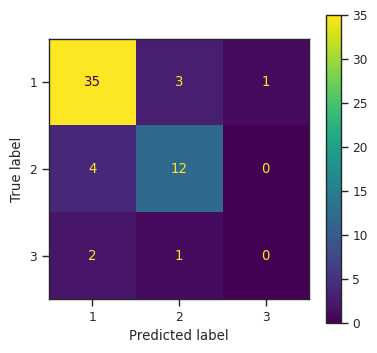

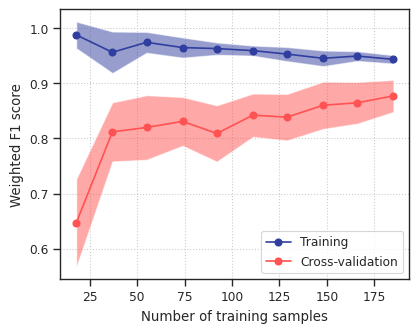

In [17]:
hasMissingVals, modelName = 'NoNull', 'LRRsurf'
for disnp in X_Y_disNPS[hasMissingVals].keys():
    print(f"\nDataset: {disnp}")
    Xtrain, Xtest, yTrain, yTest = X_Y_disNPS[hasMissingVals][disnp]
    
    logReg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                random_state=RANDOM_SEED, solver='lbfgs', max_iter=1000, verbose=0, warm_start=False, n_jobs=NUM_JOBS, l1_ratio=None)  
    paramGrid = {'penalty': ['l1', 'l2', 'elasticnet'], 
                 'tol': stats.loguniform(a=1e-5, b=1e-3), 
                 'C' : stats.loguniform(a=1e-1, b=10)}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    searchResults = hyperparamTune(logReg, paramGrid, Xtrain, yTrain, scoringMetric='f1_weighted', cv=cv, numIter=1000, hideWarnings=True)
    with open(f"{DATA_DIR}/hpTune{disnp}{modelName}.pickle", 'wb') as f:
        pickle.dump(searchResults, f)

    logReg = searchResults.best_estimator_
    yPredTrainLinR, yPredTestLinR, logReg = runModel(Xtrain, yTrain, Xtest, yTest, cv, 
                                                     model=logReg, modelName=modelName, datasetName=disnp, figNameAppendix=FIG_NAME_APPENDIX,
                                                     isReg=False, showFeatCoef=False, plotFeatImp=False, verbose=True, showFig=True)

##### Random Forest Classifier


Dataset: disNP
Best score: 0.853
Best parameter combination: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 0.20112803375408705, 'max_leaf_nodes': 21, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 59}
  Running RFCsurf
  Trained and tested using Weighted F1 score.
    Training score: 0.922
    Cross-validation score: 0.853 +/- 0.026
    Testing score:
              precision    recall  f1-score   support

     Class 1      0.857     0.923     0.889        39
     Class 2      0.812     0.812     0.812        16
     Class 3      0.000     0.000     0.000         3

    accuracy                          0.845        58
   macro avg      0.557     0.579     0.567        58
weighted avg      0.800     0.845     0.822        58

      F1 score: 0.845


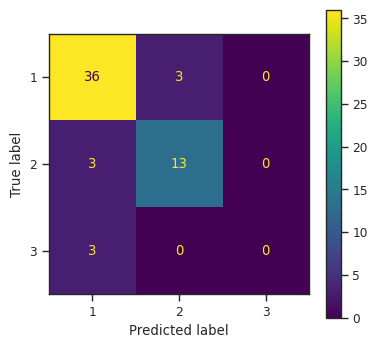

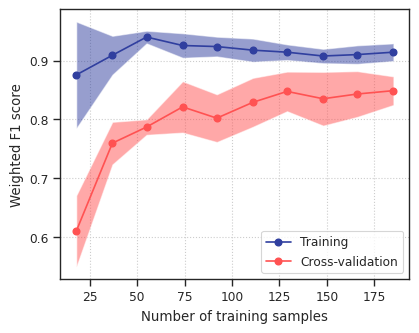

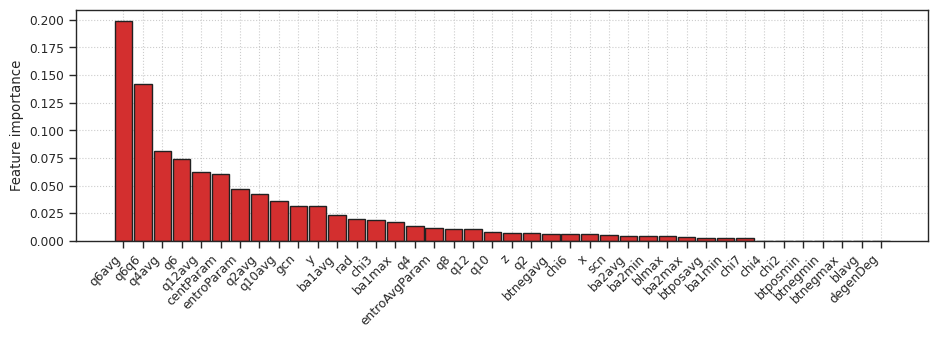

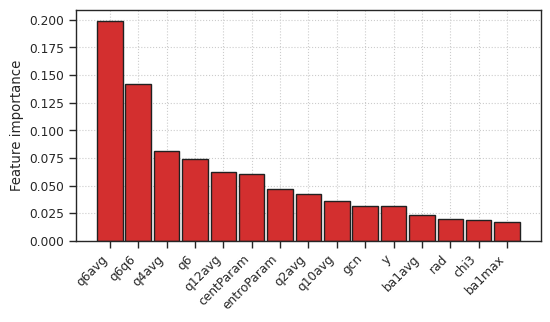

In [18]:
hasMissingVals, modelName = 'WithNull', 'RFCsurf'
for disnp in X_Y_disNPS[hasMissingVals].keys():
    print(f"\nDataset: {disnp}")
    # if exists(f"{DATA_DIR}/hpTune{disnp}{modelName}.pickle"):
    #     print('Already done, skipping...')
    #     continue
    Xtrain, Xtest, yTrain, yTest = X_Y_disNPS[hasMissingVals][disnp]
    
    rfClass = RandomForestClassifier(n_estimators=30, criterion='gini', max_depth=None, 
                                     max_features=1.0, max_leaf_nodes=None, min_samples_split=2, min_samples_leaf=1, 
                                     min_impurity_decrease=0.0, min_weight_fraction_leaf=0.0, n_jobs=NUM_JOBS, random_state=RANDOM_SEED, verbose=0, 
                                     bootstrap=True, oob_score=False, warm_start=False, ccp_alpha=0.0, class_weight=None, max_samples=None, monotonic_cst=None)
    paramGrid = {'criterion': ['gini', 'entropy', 'log_loss'], 
                 'n_estimators': stats.randint(low=5, high=80), 
                 'max_depth' : stats.randint(low=1, high=4), 
                 'max_features': stats.uniform(loc=0.1, scale=0.9), 
                 'max_leaf_nodes': stats.randint(low=10, high=50),
                 'min_samples_split': stats.randint(low=2, high=10), 
                 'min_samples_leaf': stats.randint(low=1, high=5)}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    searchResults = hyperparamTune(rfClass, paramGrid, Xtrain, yTrain, scoringMetric='f1_weighted', cv=cv, numIter=1000)
    with open(f"{DATA_DIR}/hpTune{disnp}{modelName}.pickle", 'wb') as f:
        pickle.dump(searchResults, f)

    rfClass = searchResults.best_estimator_
    yPredTrainRFR, yPredTestRFR, rfClass = runModel(Xtrain, yTrain, Xtest, yTest, cv,
                                                    model=rfClass, modelName=modelName, datasetName=disnp, figNameAppendix=FIG_NAME_APPENDIX,
                                                    numFeat=15, isReg=False, showFeatCoef=False, plotFeatImp=True, verbose=True, showFig=True)
    # Note: Set 'showFig' to False for cluster jobs!

In [19]:
numFeats = 15
featImps = []
for (i, feat) in enumerate(rfClass.feature_names_in_):
    featImps.append((feat, rfClass.feature_importances_[i]))
print(f"Top {numFeats} most important features:")
topImpFeats = [featScoreTup[0] for featScoreTup in sorted(featImps, key=lambda x: x[1], reverse=True)[:numFeats]]
print(topImpFeats)

Top 15 most important features:
['q6avg', 'q6q6', 'q4avg', 'q6', 'q12avg', 'centParam', 'entroParam', 'q2avg', 'q10avg', 'gcn', 'y', 'ba1avg', 'rad', 'chi3', 'ba1max']


In [20]:
atomClustersDF = pd.get_dummies(disNPDF['surfAtomClusters'])
atomClustersDF.columns = [f"class{i + 1}" for i in range(len(atomClustersDF.columns))]
with open(f"{DATA_DIR}/dfAlls.pickle", 'rb') as f:
    dfAlls = pickle.load(f)

df = pd.concat([dfAlls[36][topImpFeats], atomClustersDF], axis=1)
df.to_csv(f"{DATA_DIR}/disNPsurfImpFeats.csv", sep=',', index=False)

### Causal Feature Analysis

In [139]:
with open(f"{DATA_DIR}/dfAlls.pickle", 'rb') as f:
    disNPoriDF = pickle.load(f)[36]
disNPoriDF['surfAtomClusters'] = disNPDF['surfAtomClusters']
df = disNPoriDF[(disNPoriDF['surfAtomClusters'] == 2) | (disNPoriDF['surfAtomClusters'] == 3)].sort_values(by='surfAtomClusters')

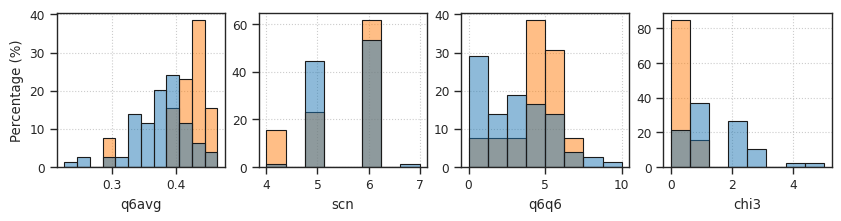

In [140]:
fig, axs = plt.subplots(1, 4, figsize=(10, 2), dpi=DPI, )   # sharey=True
sns.histplot(data=df, x='q6avg', hue='surfAtomClusters', 
             palette='tab10', edgecolor='k', alpha=0.5, multiple='layer', element='bars', fill=True, ax=axs[0],
             stat='percent', bins='auto', common_norm=False, kde=False)
axs[0].set_ylabel('Percentage (%)')
axs[0].grid(linestyle='dotted')
axs[0].get_legend().remove()
sns.histplot(data=df, x='scn', hue='surfAtomClusters', 
             palette='tab10', edgecolor='k', alpha=0.5, multiple='layer', element='bars', fill=True, ax=axs[1],
             stat='percent', bins='auto', common_norm=False, kde=False)
axs[1].set_ylabel('')
axs[1].grid(linestyle='dotted')
axs[1].legend([],[], frameon=False)
sns.histplot(data=df, x='q6q6', hue='surfAtomClusters', 
             palette='tab10', edgecolor='k', alpha=0.5, multiple='layer', element='bars', fill=True, ax=axs[2],
             stat='percent', bins='auto', common_norm=False, kde=False)
axs[2].set_ylabel('')
axs[2].grid(linestyle='dotted')
axs[2].get_legend().remove()
sns.histplot(data=df, x='chi3', hue='surfAtomClusters', 
             palette='tab10', edgecolor='k', alpha=0.5, multiple='layer', element='bars', fill=True, ax=axs[3],
             stat='percent', bins='auto', common_norm=False, kde=False)
axs[3].set_ylabel('')
axs[3].grid(linestyle='dotted')
axs[3].get_legend().remove()
# handles, labels = plt.gca().get_legend_handles_labels()
# fig.legend(handles, [1, 2], title='Pattern Class', loc='upper center', ncol=2)
plt.savefig(f"{FIG_DIR}/surfPattClass23FeatsRange.png", bbox_inches='tight')